In [1]:
# import libraries

import torch 
from torchvision import transforms, datasets
from torch import nn, optim
import torch.nn.functional as f
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

# Download and load the train data
data_train = datasets.FashionMNIST('F_MNIST', download=True, train=True, transform=transform)
loader_train = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True)

# Download and load the test data
data_test = datasets.FashionMNIST('F_MNIST', download=True, train=False, transform=transform)
loader_test = torch.utils.data.DataLoader(data_test, batch_size=34, shuffle=True)

In [3]:
# Define network architecture

class Network(nn.Module):

  def __init__(self, layers, drop_p=0.2):
    super().__init__()
    self.hidden_size = nn.ModuleList()

    # Dropout module with 0.2 drop probability
    self.dropout = nn.Dropout(p=drop_p)

    # Add a variable number of more hidden layers
    for input_size, out_size in zip(layers, layers[1:]):
      self.hidden_size.append(nn.Linear(input_size, out_size))

    # Forward pass
  def forward(self, activision):
      # make sure input tensor is flattened
      activision = activision.view(activision.shape[0], -1)
      
      # number of hidden layers, integer
      num_layers = len(self.hidden_size)

      # Forward pass through the network, returns the output logits 
      for (length, linear_tform) in zip(range(num_layers), self.hidden_size):
        if length < num_layers - 1:
          activision = self.dropout(f.relu(linear_tform(activision))) 
        else:
          activision = f.log_softmax(linear_tform(activision), dim=1)

      return activision


def validation(model, loader_test, criterion):
  '''To test for overfitting while training, 
  we measure the performance on data not in the training set called the validation set 
  '''
  
  loss_test = 0
  accuracy = 0
  # validation pass here
  for imgs, labels in loader_test:
    log_ps = model(imgs)
    loss_test += criterion(log_ps, labels)

    # Calculating the accuracy 
    ps = torch.exp(log_ps)

    # Class with highest probability is our predicted class, compare with true label
    # This "top_p" tensor is the actual probability value
    # The 'top_k' tensor are the class indices themselves
    top_p, top_k = ps.topk(1, dim=1)
    equality = (top_k == labels.view(*top_k.shape))

    # Accuracy is number of correct predictions divided by all predictions, just take the mean
    accuracy += torch.mean(equality.type(torch.FloatTensor))

  return loss_test, accuracy



def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(11,13), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

In [4]:
# create the network, define the criterion and optimizer
model = Network(layers=[784, 512, 256, 128, 64, 10]) # input: 28x28 = 784, hidden:[512,256,128,64], output:10
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

**Train the network here**:

The general process with PyTorch:

-Make a forward pass through the network

-Use the network output to calculate the loss

-Perform a backward pass through the network with loss.backward() to calculate the gradients

-Take a step with the optimizer to update the weights

In [5]:
epochs = 20
train_loss, test_loss = [], []
accuracy = 0

for epoch in range(epochs):
  running_loss = 0
  
  for images, label in loader_train:

    optimizer.zero_grad()

    logps = model(images)
    loss = criterion(logps, label)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  else:
    # set model to evaluation mod
    model.eval()

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
      loss_test, accuracy = validation(model, loader_test, criterion)
      
    # set model back to train mode
    model.train()

    # mean loss to enable comparison between train and test sets
    train_loss.append(running_loss / len(loader_train))
    test_loss.append(loss_test / len(loader_test))

    if epoch >= (epochs - 6):
      print('Epoch: {}/{}:'.format(epoch+1, epochs),
          '"Training Loss: {:.3f}'.format(running_loss/len(loader_train)),
          'Test Loss: {:.3f}'.format(loss_test / len(loader_test)),
          'Test Accuracy: {:.1f}%'.format((accuracy / len(loader_test))*100))


Epoch: 15/20: "Training Loss: 0.276 Test Loss: 0.349 Test Accuracy: 88.0%
Epoch: 16/20: "Training Loss: 0.270 Test Loss: 0.344 Test Accuracy: 88.4%
Epoch: 17/20: "Training Loss: 0.265 Test Loss: 0.342 Test Accuracy: 88.7%
Epoch: 18/20: "Training Loss: 0.262 Test Loss: 0.357 Test Accuracy: 88.1%
Epoch: 19/20: "Training Loss: 0.257 Test Loss: 0.345 Test Accuracy: 88.7%
Epoch: 20/20: "Training Loss: 0.254 Test Loss: 0.332 Test Accuracy: 88.8%


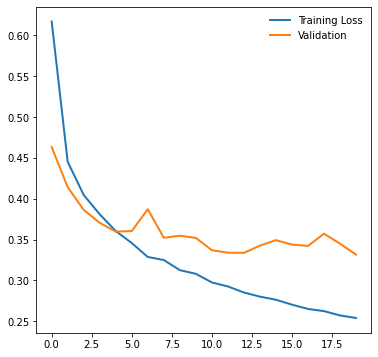

In [9]:
# we can see what the actual training && validation losses look as we were training this network now
plt.figure(figsize=(6,6))
plt.plot(train_loss, label='Training Loss', linewidth=2)
plt.plot(test_loss, label='Validation', linewidth=2)
plt.legend(frameon=False);

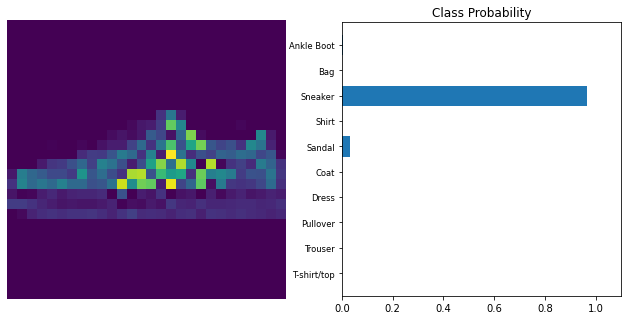

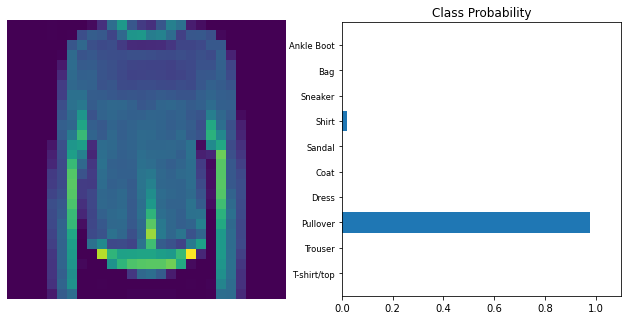

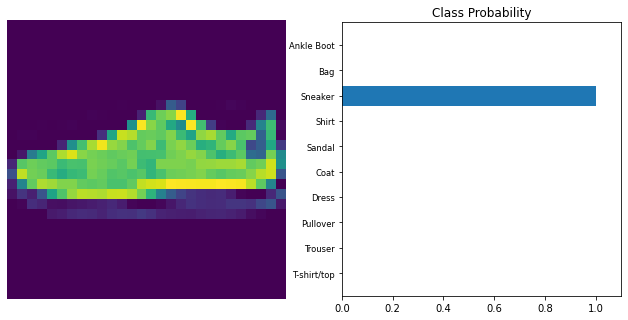

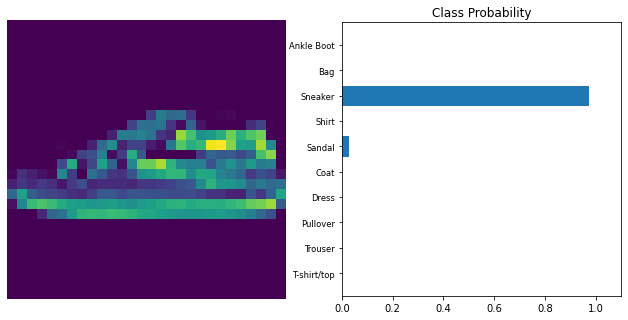

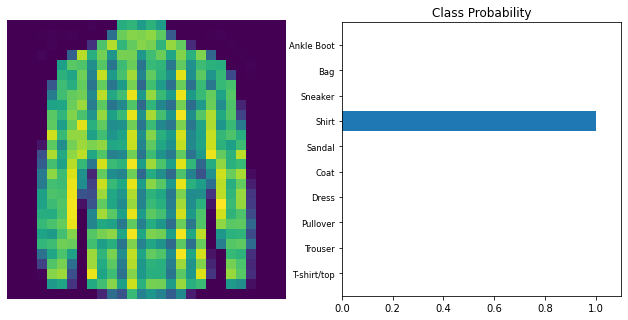

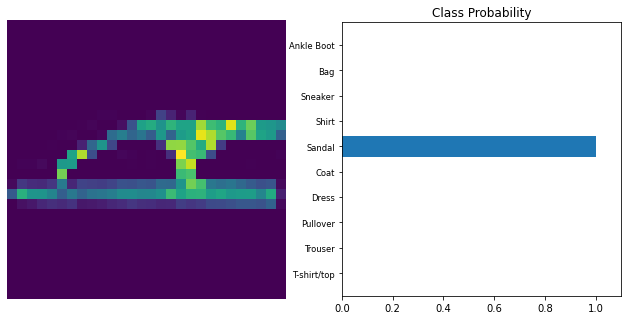

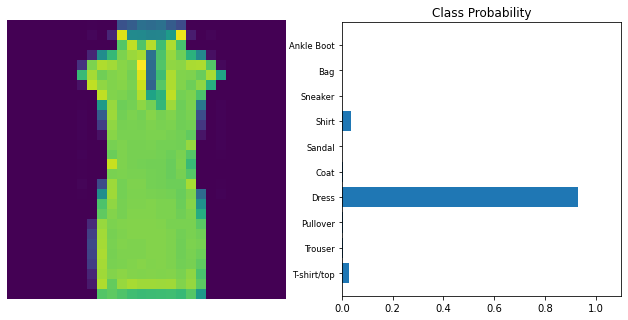

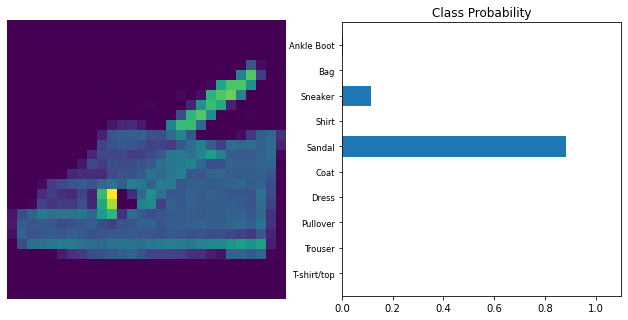

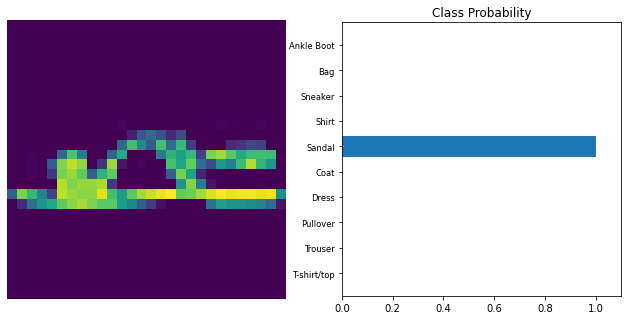

In [7]:
step = 0

# Now that the model is trained, we can use it for inference. 
model.eval()
for imgs, labels in loader_train:
  step += 1
  imgs = imgs.resize_(1, 784)
  if step == 10:
    break

  with torch.no_grad():
    log_ps = model(imgs) 
  ps = torch.exp(log_ps)
  # Plot the image && probabilities
  view_classify(imgs, ps)